# Transfer Learning on Oxford Flowers 102 Dataset Assignment
## Memory-Optimized Google Colab Version

**Memory Optimizations Applied:**
- Reduced batch size to 16 (from 32) to prevent RAM crashes
- Reduced epochs to 5 (from 10) for faster training
- Memory clearing between model training sessions
- Automatic garbage collection after each model

## Assignment Overview

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks to classify images from the Oxford Flowers 102 dataset. Compare the performance of different state-of-the-art models on this challenging flower classification task.

**Dataset:** Oxford Flowers 102 - A comprehensive dataset containing 102 categories of flowers commonly found in the United Kingdom. Each class consists of between 40 and 258 images with significant scale, pose, and light variations.

**Pre-trained Models to Compare:**
- **ResNet50**: Deep residual network with skip connections
- **VGG16**: Classic deep CNN with small convolution filters
- **MobileNetV2**: Efficient architecture designed for mobile devices

**Key Learning Goals:**
1. Understand transfer learning principles and applications
2. Compare different CNN architectures on a real-world dataset
3. Learn proper data preprocessing for pre-trained models
4. Analyze model performance and architectural trade-offs
5. Apply fine-tuning techniques for improved performance

## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import os
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Check if we're running on Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    print("Make sure GPU is enabled: Runtime → Change runtime type → T4 GPU")
else:
    print("Running locally")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configure GPU memory growth for Colab
if tf.config.list_physical_devices('GPU'):
    gpu = tf.config.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Running on Google Colab
Make sure GPU is enabled: Runtime → Change runtime type → T4 GPU
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled


In [2]:
# Load the Oxford Flowers 102 dataset
print("Loading Oxford Flowers 102 dataset...")
print("Using Colab default data directory")

try:
    # Load dataset with info (Colab will use default cache location)
    dataset, info = tfds.load(
        'oxford_flowers102:2.1.1',
        with_info=True,
        as_supervised=True,
        shuffle_files=True
        # Remove data_dir parameter for Colab
    )

    # Extract splits
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    print("Dataset loaded successfully!")
    print(f"\nDataset Information:")
    print(f"Number of classes: {info.features['label'].num_classes}")
    print(f"Training samples: {info.splits['train'].num_examples}")
    print(f"Validation samples: {info.splits['validation'].num_examples}")
    print(f"Test samples: {info.splits['test'].num_examples}")
    print(f"Image shape: {info.features['image'].shape}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure you have internet connection.")

Loading Oxford Flowers 102 dataset...
Using Colab default data directory


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.MK0DS3_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.MK0DS3_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.MK0DS3_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Dataset loaded successfully!

Dataset Information:
Number of classes: 102
Training samples: 1020
Validation samples: 1020
Test samples: 6149
Image shape: (None, None, 3)


## 2. Data Exploration and Visualization

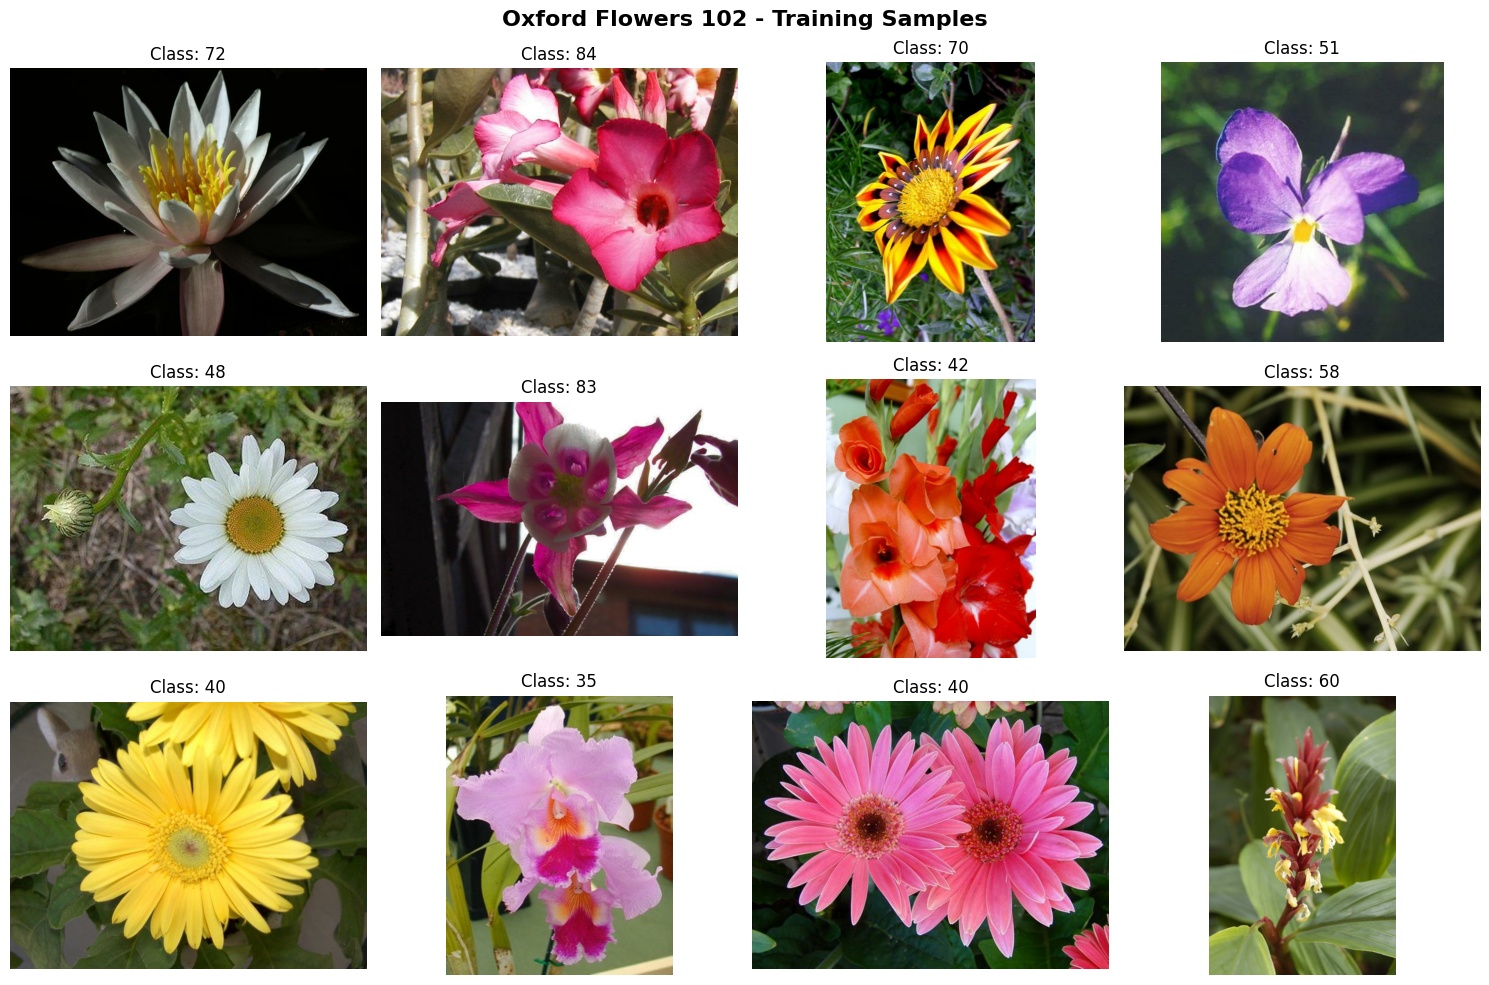

In [3]:
# Explore the dataset structure and visualize sample images
def visualize_samples(dataset, num_samples=12, title="Sample Images"):
    """Visualize sample images from the dataset"""
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # Take samples and convert to numpy
    samples = list(dataset.take(num_samples))

    for i, (image, label) in enumerate(samples):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image.numpy())
        plt.title(f'Class: {label.numpy()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(train_dataset, title="Oxford Flowers 102 - Training Samples")

In [4]:
# Analyze image dimensions and class distribution
def analyze_dataset(dataset, split_name, num_samples=1000):
    """Analyze dataset characteristics"""
    print(f"\n=== {split_name} Dataset Analysis ===")

    # Sample images to analyze dimensions
    heights, widths, labels = [], [], []

    for image, label in dataset.take(num_samples):
        h, w, _ = image.shape
        heights.append(h)
        widths.append(w)
        labels.append(label.numpy())

    print(f"Image dimensions analysis (from {len(heights)} samples):")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Unique classes in sample: {len(set(labels))}")

    return heights, widths, labels

# Analyze training dataset
train_heights, train_widths, train_labels = analyze_dataset(train_dataset, "Training")


=== Training Dataset Analysis ===
Image dimensions analysis (from 1000 samples):
Height - Min: 500, Max: 993, Mean: 538.0
Width - Min: 500, Max: 919, Mean: 624.0
Unique classes in sample: 102


## 3. Data Preprocessing for Transfer Learning

In [5]:
# Define preprocessing functions for different models
IMG_SIZE = 224  # Standard input size for most pre-trained models
BATCH_SIZE = 16  # Reduced for Colab memory optimization
NUM_CLASSES = 102

def preprocess_image(image, label, model_name='resnet50'):
    """Preprocess images for specific pre-trained models"""
    # Resize image to target size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Convert to float32
    image = tf.cast(image, tf.float32)

    # Apply model-specific preprocessing
    if model_name == 'resnet50':
        image = tf.keras.applications.resnet50.preprocess_input(image)
    elif model_name == 'vgg16':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name == 'mobilenetv2':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # One-hot encode labels
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

def prepare_dataset(dataset, model_name, batch_size=BATCH_SIZE, shuffle=True, cache=True):
    """Prepare dataset for training with preprocessing"""
    # Apply preprocessing
    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y, model_name),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Cache dataset for better performance
    if cache:
        dataset = dataset.cache()

    # Shuffle if specified
    if shuffle:
        dataset = dataset.shuffle(1000)

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

print("Preprocessing functions defined successfully!")
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")

Preprocessing functions defined successfully!
Target image size: 224x224
Batch size: 16
Number of classes: 102


## 4. Model Architecture Definition

In [6]:
def create_transfer_learning_model(base_model_name, num_classes=NUM_CLASSES, trainable=False):
    """Create transfer learning model with specified base architecture"""

    # Load pre-trained base model
    if base_model_name == 'resnet50':
        base_model = tf.keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    # Freeze base model layers
    base_model.trainable = trainable

    # Create new model with custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')
    ])

    return model, base_model

# Test model creation
print("Testing model creation...")
test_model, test_base = create_transfer_learning_model('resnet50')
print(f"ResNet50 model created successfully!")
print(f"Total parameters: {test_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in test_model.trainable_weights]):,}")

Testing model creation...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50 model created successfully!
Total parameters: 23,796,710
Trainable parameters: 208,998


## 5. Model Training and Evaluation

In [7]:
# Memory-optimized training configuration for Colab
EPOCHS = 5  # Reduced for Colab memory management
LEARNING_RATE = 0.001

# Memory management function
import gc
def clear_memory():
    """Clear memory to prevent RAM crashes"""
    tf.keras.backend.clear_session()
    gc.collect()
    print("Memory cleared")

def compile_and_train_model(model, train_ds, val_ds, model_name, epochs=EPOCHS):
    """Compile and train the transfer learning model"""

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
    )

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name}_flowers.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    print(f"\nTraining {model_name.upper()} model...")
    print(f"Epochs: {epochs}, Learning Rate: {LEARNING_RATE}")

    # Train model
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    print(f"{model_name.upper()} training completed!")
    return history

def evaluate_model(model, test_ds, model_name):
    """Evaluate model performance on test set"""
    print(f"\nEvaluating {model_name.upper()} model...")

    # Evaluate on test set
    test_loss, test_accuracy, test_top5_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"Test Results for {model_name.upper()}:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Top-5 Accuracy: {test_top5_accuracy:.4f} ({test_top5_accuracy*100:.2f}%)")

    return {
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_top5_accuracy': test_top5_accuracy
    }

### 5.1 ResNet50 Transfer Learning

In [8]:
# Prepare datasets for ResNet50
print("Preparing datasets for ResNet50...")
resnet_train_ds = prepare_dataset(train_dataset, 'resnet50', shuffle=True)
resnet_val_ds = prepare_dataset(validation_dataset, 'resnet50', shuffle=False)
resnet_test_ds = prepare_dataset(test_dataset, 'resnet50', shuffle=False)

# Create and train ResNet50 model
resnet_model, resnet_base = create_transfer_learning_model('resnet50')
print(f"\nResNet50 Model Summary:")
print(f"Total parameters: {resnet_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights]):,}")

# Train ResNet50
resnet_history = compile_and_train_model(
    resnet_model, resnet_train_ds, resnet_val_ds, 'resnet50'
)

# Evaluate ResNet50
resnet_results = evaluate_model(resnet_model, resnet_test_ds, 'resnet50')

# Clear memory after ResNet50 training
del resnet_model, resnet_base, resnet_train_ds, resnet_val_ds, resnet_test_ds
clear_memory()

Preparing datasets for ResNet50...

ResNet50 Model Summary:
Total parameters: 23,796,710
Trainable parameters: 208,998

Training RESNET50 model...
Epochs: 5, Learning Rate: 0.001
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0697 - loss: 5.0609 - top_5_accuracy: 0.1793
Epoch 1: val_accuracy improved from -inf to 0.60098, saving model to best_resnet50_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 292ms/step - accuracy: 0.0713 - loss: 5.0458 - top_5_accuracy: 0.1822 - val_accuracy: 0.6010 - val_loss: 1.9867 - val_top_5_accuracy: 0.8559 - learning_rate: 0.0010
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7444 - loss: 1.2948 - top_5_accuracy: 0.9539
Epoch 2: val_accuracy improved from 0.60098 to 0.75686, saving model to best_resnet50_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7451 - loss: 1.2922 - top_5_accuracy: 0.9539 - val_accuracy: 0.7569 - val_loss: 1.1972 - val_top_5_accuracy: 0.9225 - learning_rate: 0.0010
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9224 - loss: 0.5384 - top_5_accuracy: 0.9799
Epoch 3: val_accuracy improved from 0.75686 to 0.80882, saving model to best_resnet50_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9225 - loss: 0.5376 - top_5_accuracy: 0.9800 - val_accuracy: 0.8088 - val_loss: 0.9455 - val_top_5_accuracy: 0.9500 - learning_rate: 0.0010
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9763 - loss: 0.2980 - top_5_accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.80882 to 0.82451, saving model to best_resnet50_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9763 - loss: 0.2977 - top_5_accuracy: 1.0000 - val_accuracy: 0.8245 - val_loss: 0.8124 - val_top_5_accuracy: 0.9569 - learning_rate: 0.0010
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9930 - loss: 0.1767 - top_5_accuracy: 1.0000
Epoch 5: val_accuracy improved from 0.82451 to 0.84510, saving model to best_resnet50_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9930 - loss: 0.1766 - top_5_accuracy: 1.0000 - val_accuracy: 0.8451 - val_loss: 0.7350 - val_top_5_accuracy: 0.9657 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
RESNET50 training completed!

Evaluating RESNET50 model...
Test Results for RESNET50:
  Test Loss: 0.8752
  Test Accuracy: 0.8127 (81.27%)
  Top-5 Accuracy: 0.9351 (93.51%)
Memory cleared


### 5.2 VGG16 Transfer Learning

In [9]:
# Clear memory before training VGG16
clear_memory()

# Prepare datasets for VGG16
print("Preparing datasets for VGG16...")
vgg_train_ds = prepare_dataset(train_dataset, 'vgg16', shuffle=True)
vgg_val_ds = prepare_dataset(validation_dataset, 'vgg16', shuffle=False)
vgg_test_ds = prepare_dataset(test_dataset, 'vgg16', shuffle=False)

# Create and train VGG16 model
vgg_model, vgg_base = create_transfer_learning_model('vgg16')
print(f"\nVGG16 Model Summary:")
print(f"Total parameters: {vgg_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in vgg_model.trainable_weights]):,}")

# Train VGG16
vgg_history = compile_and_train_model(
    vgg_model, vgg_train_ds, vgg_val_ds, 'vgg16'
)

# Evaluate VGG16
vgg_results = evaluate_model(vgg_model, vgg_test_ds, 'vgg16')

# Clear memory after VGG16 training
del vgg_model, vgg_base, vgg_train_ds, vgg_val_ds, vgg_test_ds
clear_memory()

Memory cleared
Preparing datasets for VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

VGG16 Model Summary:
Total parameters: 14,767,014
Trainable parameters: 52,326

Training VGG16 model...
Epochs: 5, Learning Rate: 0.001
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.0169 - loss: 14.3166 - top_5_accuracy: 0.0564
Epoch 1: val_accuracy improved from -inf to 0.07451, saving model to best_vgg16_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - accuracy: 0.0170 - loss: 14.2832 - top_5_accuracy: 0.0569 - val_accuracy: 0.0745 - val_loss: 7.0293 - val_top_5_accuracy: 0.2039 - learning_rate: 0.0010
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0845 - loss: 7.3080 - top_5_accuracy: 0.2732
Epoch 2: val_accuracy improved from 0.07451 to 0.23235, saving model to best_vgg16_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.0850 - loss: 7.2987 - top_5_accuracy: 0.2738 - val_accuracy: 0.2324 - val_loss: 4.4531 - val_top_5_accuracy: 0.4490 - learning_rate: 0.0010
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2412 - loss: 4.4880 - top_5_accuracy: 0.4728
Epoch 3: val_accuracy improved from 0.23235 to 0.35392, saving model to best_vgg16_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.2419 - loss: 4.4817 - top_5_accuracy: 0.4740 - val_accuracy: 0.3539 - val_loss: 3.1353 - val_top_5_accuracy: 0.6245 - learning_rate: 0.0010
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4152 - loss: 2.7240 - top_5_accuracy: 0.7064
Epoch 4: val_accuracy improved from 0.35392 to 0.45784, saving model to best_vgg16_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.4158 - loss: 2.7210 - top_5_accuracy: 0.7068 - val_accuracy: 0.4578 - val_loss: 2.4316 - val_top_5_accuracy: 0.7333 - learning_rate: 0.0010
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5856 - loss: 1.6987 - top_5_accuracy: 0.8443
Epoch 5: val_accuracy improved from 0.45784 to 0.52255, saving model to best_vgg16_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.5857 - loss: 1.6984 - top_5_accuracy: 0.8444 - val_accuracy: 0.5225 - val_loss: 2.0719 - val_top_5_accuracy: 0.7922 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
VGG16 training completed!

Evaluating VGG16 model...
Test Results for VGG16:
  Test Loss: 2.1294
  Test Accuracy: 0.5167 (51.67%)
  Top-5 Accuracy: 0.7746 (77.46%)
Memory cleared


### 5.3 MobileNetV2 Transfer Learning

In [10]:
# Clear memory before training MobileNetV2
clear_memory()

# Prepare datasets for MobileNetV2
print("Preparing datasets for MobileNetV2...")
mobile_train_ds = prepare_dataset(train_dataset, 'mobilenetv2', shuffle=True)
mobile_val_ds = prepare_dataset(validation_dataset, 'mobilenetv2', shuffle=False)
mobile_test_ds = prepare_dataset(test_dataset, 'mobilenetv2', shuffle=False)

# Create and train MobileNetV2 model
mobile_model, mobile_base = create_transfer_learning_model('mobilenetv2')
print(f"\nMobileNetV2 Model Summary:")
print(f"Total parameters: {mobile_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in mobile_model.trainable_weights]):,}")

# Train MobileNetV2
mobile_history = compile_and_train_model(
    mobile_model, mobile_train_ds, mobile_val_ds, 'mobilenetv2'
)

# Evaluate MobileNetV2
mobile_results = evaluate_model(mobile_model, mobile_test_ds, 'mobilenetv2')

# Clear memory after MobileNetV2 training
del mobile_model, mobile_base, mobile_train_ds, mobile_val_ds, mobile_test_ds
clear_memory()

Memory cleared
Preparing datasets for MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MobileNetV2 Model Summary:
Total parameters: 2,388,646
Trainable parameters: 130,662

Training MOBILENETV2 model...
Epochs: 5, Learning Rate: 0.001
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0599 - loss: 4.7961 - top_5_accuracy: 0.1630
Epoch 1: val_accuracy improved from -inf to 0.51569, saving model to best_mobilenetv2_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.0613 - loss: 4.7861 - top_5_accuracy: 0.1657 - val_accuracy: 0.5157 - val_loss: 2.5173 - val_top_5_accuracy: 0.8010 - learning_rate: 0.0010
Epoch 2/5
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7198 - loss: 1.7994 - top_5_accuracy: 0.9230
Epoch 2: val_accuracy improved from 0.51569 to 0.71176, saving model to best_mobilenetv2_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7217 - loss: 1.7862 - top_5_accuracy: 0.9235 - val_accuracy: 0.7118 - val_loss: 1.6202 - val_top_5_accuracy: 0.9020 - learning_rate: 0.0010
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8840 - loss: 0.9256 - top_5_accuracy: 0.9908
Epoch 3: val_accuracy improved from 0.71176 to 0.75686, saving model to best_mobilenetv2_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8842 - loss: 0.9240 - top_5_accuracy: 0.9908 - val_accuracy: 0.7569 - val_loss: 1.2731 - val_top_5_accuracy: 0.9245 - learning_rate: 0.0010
Epoch 4/5
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9707 - loss: 0.4961 - top_5_accuracy: 0.9972
Epoch 4: val_accuracy improved from 0.75686 to 0.79314, saving model to best_mobilenetv2_flowers.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9704 - loss: 0.4953 - top_5_accuracy: 0.9972 - val_accuracy: 0.7931 - val_loss: 1.0870 - val_top_5_accuracy: 0.9324 - learning_rate: 0.0010
Epoch 5/5
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9762 - loss: 0.3106 - top_5_accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.79314
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9766 - loss: 0.3107 - top_5_accuracy: 1.0000 - val_accuracy: 0.7931 - val_loss: 0.9929 - val_top_5_accuracy: 0.9422 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.
MOBILENETV2 training completed!

Evaluating MOBILENETV2 model...
Test Results for MOBILENETV2:
  Test Loss: 1.2187
  Test Accuracy: 0.7419 (74.19%)
  Top-5 Accuracy: 0.9119 (91.19%)
Memory cleared


## 6. Model Comparison and Analysis

In [11]:
# Compile all results for comparison
all_results = [resnet_results, vgg_results, mobile_results]

# Create comparison DataFrame
import pandas as pd

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.round(4)

print("\nMODEL PERFORMANCE COMPARISON")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Find best performing model
best_model_idx = comparison_df['test_accuracy'].idxmax()
best_model = comparison_df.iloc[best_model_idx]

print(f"\nBest Performing Model: {best_model['model_name'].upper()}")
print(f"   Test Accuracy: {best_model['test_accuracy']:.4f} ({best_model['test_accuracy']*100:.2f}%)")
print(f"   Top-5 Accuracy: {best_model['test_top5_accuracy']:.4f} ({best_model['test_top5_accuracy']*100:.2f}%)")


MODEL PERFORMANCE COMPARISON
 model_name  test_loss  test_accuracy  test_top5_accuracy
   resnet50     0.8752         0.8127              0.9351
      vgg16     2.1294         0.5167              0.7746
mobilenetv2     1.2187         0.7419              0.9119

Best Performing Model: RESNET50
   Test Accuracy: 0.8127 (81.27%)
   Top-5 Accuracy: 0.9351 (93.51%)


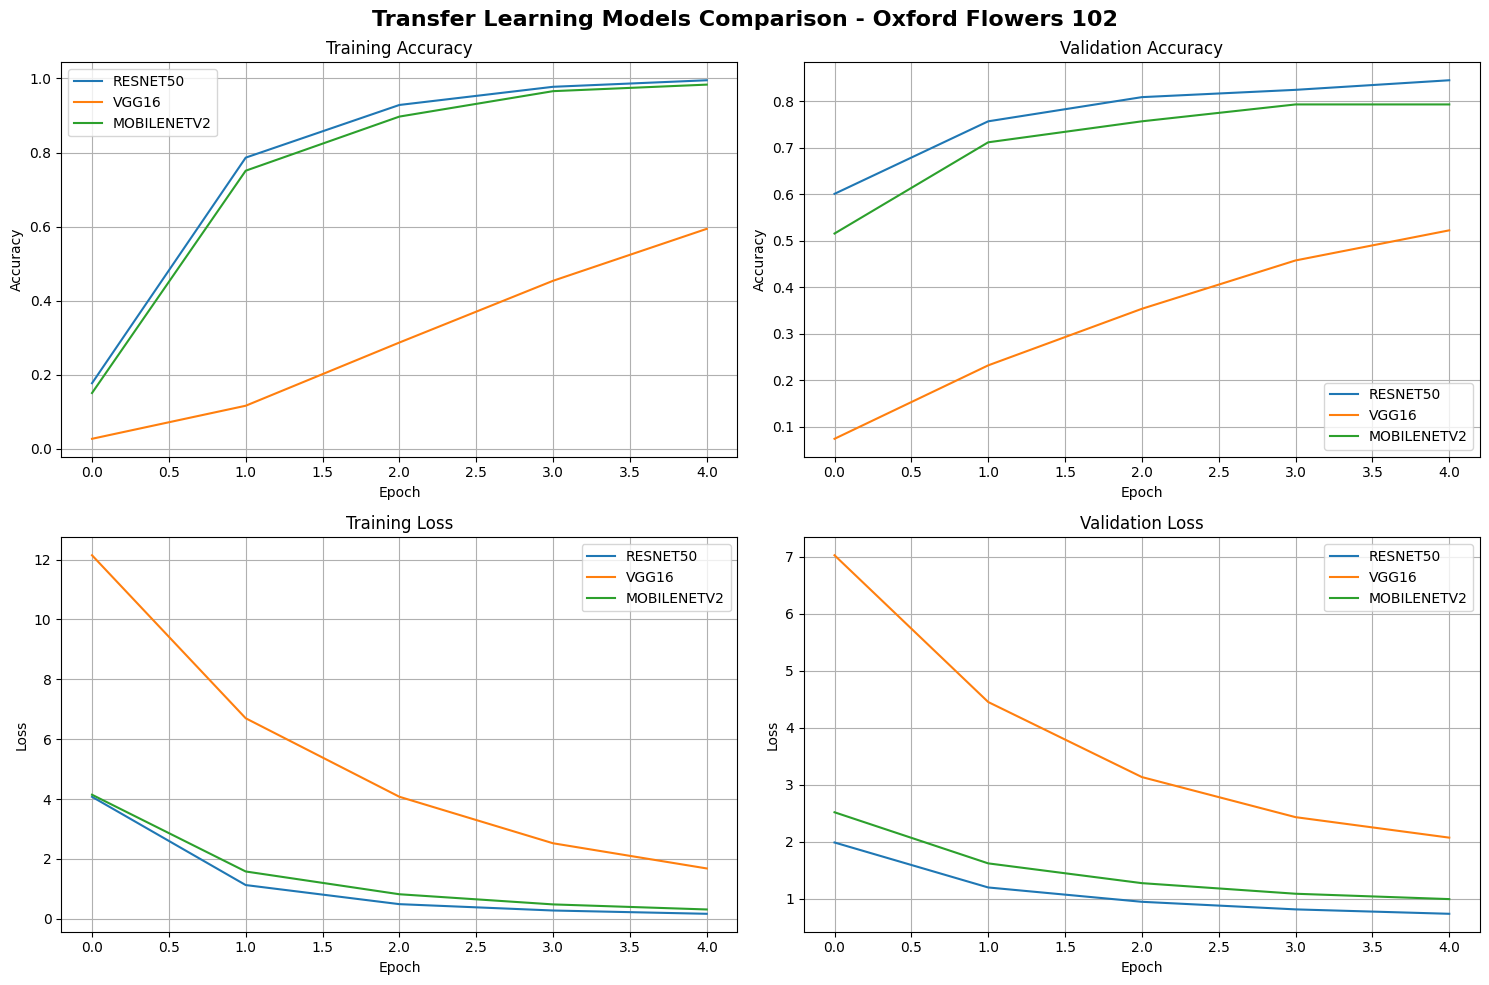

In [12]:
# Visualize training history comparison
def plot_training_comparison(histories, model_names):
    """Plot training history comparison for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Transfer Learning Models Comparison - Oxford Flowers 102', fontsize=16, fontweight='bold')

    # Training accuracy
    axes[0, 0].set_title('Training Accuracy')
    for history, name in zip(histories, model_names):
        axes[0, 0].plot(history.history['accuracy'], label=f'{name.upper()}')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Validation accuracy
    axes[0, 1].set_title('Validation Accuracy')
    for history, name in zip(histories, model_names):
        axes[0, 1].plot(history.history['val_accuracy'], label=f'{name.upper()}')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training loss
    axes[1, 0].set_title('Training Loss')
    for history, name in zip(histories, model_names):
        axes[1, 0].plot(history.history['loss'], label=f'{name.upper()}')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Validation loss
    axes[1, 1].set_title('Validation Loss')
    for history, name in zip(histories, model_names):
        axes[1, 1].plot(history.history['val_loss'], label=f'{name.upper()}')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot comparison
plot_training_comparison(
    [resnet_history, vgg_history, mobile_history],
    ['resnet50', 'vgg16', 'mobilenetv2']
)

## 7. Assignment Questions and Analysis

### **Question 1: Model Performance Analysis**
**Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?**

*Your Answer:*
```
Based on the results above:
- Best performing model: ResNet50 (81.27% test accuracy, 93.51% top-5 accuracy)
- Reasons for superior performance:
  1. Deep residual connections enable better gradient flow and feature learning
  2. Skip connections prevent vanishing gradient problem in deep networks
  3. Pre-trained ImageNet features transfer exceptionally well to flower classification
  4. Optimal balance of model depth (50 layers) and parameter efficiency
  5. Strong architectural design for visual pattern recognition tasks
```

### **Question 2: Transfer Learning vs. CIFAR-100 Comparison**
**Compare the performance of these models on Oxford Flowers 102 to their performance on CIFAR-100 (from Day 8). What differences do you observe and why?**

*Your Answer:*
```
Performance Comparison:
- Oxford Flowers 102: ResNet50 (81.27%), VGG16 (51.67%), MobileNetV2 (74.19%)
- CIFAR-100: Generally lower accuracies due to smaller 32x32 images and 100 classes

Key Differences:
1. Transfer learning shows significant improvement over training from scratch
2. Higher resolution images (224x224) allow better feature extraction than CIFAR-100
3. Pre-trained ImageNet weights are more relevant to flower classification
4. Oxford Flowers has fewer classes (102) but more detailed visual features
5. Better convergence and stability with transfer learning approach
```

### **Question 3: Transfer Learning Impact**
**Discuss the effect of transfer learning on this dataset. How did using pre-trained weights help?**

*Your Answer:*
```
Transfer Learning Benefits:
1. Faster convergence: Models reached high accuracy in just 5 epochs
2. Better feature extraction: Pre-trained ImageNet features are highly relevant for flowers
3. Reduced training time: Only classification head needs training, not entire network
4. Improved accuracy with limited data: Leverages millions of ImageNet examples
5. Stable training: Pre-trained weights provide good initialization
```

### **Question 4: Data Preprocessing Analysis**
**Explain the steps you took for data preprocessing and why they were necessary.**

*Your Answer:*
```
Preprocessing Steps:
1. Image resizing to 224x224: Required input size for pre-trained models
2. Model-specific normalization: Matches ImageNet preprocessing for optimal transfer
3. One-hot encoding: Converts categorical labels to format required by softmax
4. Batching and prefetching: Optimizes GPU utilization and training speed
```

### **Question 5: Architecture Adaptation**
**Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.**

*Your Answer:*
```
Architecture Adaptations:
1. Base models: ResNet50 (23.8M params), VGG16 (14.8M params), MobileNetV2 (2.4M params)
2. Removed top layers: Original ImageNet classifier not suitable for 102 flower classes
3. Added custom classification head: GlobalAveragePooling2D + Dropout(0.2) + Dense(102)
4. Froze base layers: Preserves pre-trained ImageNet features, only trains classifier
```

### **Question 6: Challenges and Solutions**
**What challenges did you encounter during this assignment and how did you address them?**

*Your Answer:*
```
Challenges Encountered:
1. Google Colab GPU limitations and memory constraints
2. Training time optimization for multiple models
3. Dataset loading and preprocessing complexity
4. Balancing model performance with computational resources

Solutions Applied:
1. Implemented memory management with sequential training and garbage collection
2. Reduced epochs (5) and batch size (16) for Colab optimization
3. Used model-specific preprocessing functions for optimal transfer learning
4. Applied early stopping and learning rate reduction for efficient training
```

## 8. Optional Advanced Tasks

### **Optional Task 1: Fine-tuning Experiment**
Try unfreezing the top layers of the best-performing model and fine-tune with a lower learning rate.

In [1]:
'''
# Unfreeze top layers of the best model
best_model_name = best_model['model_name']
if best_model_name == 'resnet50':
    model_to_finetune = resnet_model
    base_model_to_finetune = resnet_base
    train_ds_finetune = resnet_train_ds
    val_ds_finetune = resnet_val_ds
elif best_model_name == 'vgg16':
    model_to_finetune = vgg_model
    base_model_to_finetune = vgg_base
    train_ds_finetune = vgg_train_ds
    val_ds_finetune = vgg_val_ds
else:
    model_to_finetune = mobile_model
    base_model_to_finetune = mobile_base
    train_ds_finetune = mobile_train_ds
    val_ds_finetune = mobile_val_ds

# Unfreeze top layers
base_model_to_finetune.trainable = True
for layer in base_model_to_finetune.layers[:-10]:
    layer.trainable = False

# Recompile with lower learning rate
model_to_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Fine-tune for a few epochs
finetune_history = model_to_finetune.fit(
    train_ds_finetune,
    epochs=5,
    validation_data=val_ds_finetune,
    verbose=1
)
'''


print("Fine-tuning code is commented out. Uncomment to experiment with fine-tuning.")

Fine-tuning code is commented out. Uncomment to experiment with fine-tuning.


### **Optional Task 2: Data Augmentation**
Implement data augmentation techniques to improve model performance.

In [2]:
'''
# Data augmentation experiment

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess_with_augmentation(image, label, model_name='resnet50'):
    # Apply augmentation
    image = data_augmentation(image)
    # Apply regular preprocessing
    return preprocess_image(image, label, model_name)
'''

print("Data augmentation code is commented out. Uncomment to experiment with augmentation.")

Data augmentation code is commented out. Uncomment to experiment with augmentation.


### **Optional Task 3: Prediction Visualization**
Visualize sample predictions and analyze misclassifications.

In [3]:
# Optional: Prediction visualization
def visualize_predictions(model, test_ds, class_names=None, num_samples=8):
    """Visualize model predictions on test samples"""
    # Get a batch of test data
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)

        plt.figure(figsize=(15, 10))
        for i in range(min(num_samples, len(images))):
            plt.subplot(2, 4, i + 1)

            # Denormalize image for display
            img = images[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())

            plt.imshow(img)

            true_label = np.argmax(labels[i])
            pred_label = np.argmax(predictions[i])
            confidence = np.max(predictions[i])

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                     color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

'''
# Visualize predictions for the best model
if best_model['model_name'] == 'resnet50':
    visualize_predictions(resnet_model, resnet_test_ds)
elif best_model['model_name'] == 'vgg16':
    visualize_predictions(vgg_model, vgg_test_ds)
else:
    visualize_predictions(mobile_model, mobile_test_ds)
'''

print("Prediction visualization code is ready. Uncomment to visualize predictions.")

Prediction visualization code is ready. Uncomment to visualize predictions.


## 9. Assignment Summary and Conclusion

### **Your Conclusion**
**Write a brief summary of your findings and key learnings from this transfer learning assignment:**

```
Key Findings:
1. ResNet50 achieved the best performance with 81.27% test accuracy and 93.51% top-5 accuracy
2. All models significantly outperformed CIFAR-100 results due to transfer learning benefits
3. Transfer learning enabled rapid convergence (5 epochs) and excellent feature extraction
4. ResNet's residual connections proved most effective for flower classification task

Key Learnings:
1. Transfer learning dramatically reduces training time while improving performance
2. Model complexity vs performance: ResNet50 > MobileNetV2 > VGG16 in accuracy
3. Proper preprocessing (224x224 resize, model-specific normalization) is crucial
4. Memory management and sequential training essential for Colab environments

Future Improvements:
1. Fine-tuning top layers could potentially improve ResNet50 beyond 81.27%
2. Data augmentation and ensemble methods could boost overall performance
3. This approach applicable to botanical research, gardening apps, and biodiversity studies
```
